[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Bolin_1958/timescales_comparison.ipynb)

#### Timescales comparison 
##### Bolin
##### Gedzelman
- TODO urls
- TODO alpha?

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from PySDM.physics import si, in_unit
from PySDM import Formulae
from PySDM_examples.Bolin_1958.common import IsotopeTimescale
from open_atmos_jupyter_utils import show_plot
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
any_non_zero_value = 44.0
radii = np.asarray([0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.20]) * si.cm
temperature = Formulae().constants.T0 + 10 * si.K

settings = {
    "terminal_velocity":"RogersYau",
    "drop_growth":"Mason1951",
    "diffusion_thermics":"Neglect",
    "saturation_vapour_pressure":"AugustRocheMagnus",
    "ventilation":"Froessling1938",
    "particle_shape_and_density":"LiquidSpheres",
    "air_dynamic_viscosity":"ZografosEtAl1987",
    "isotope_equilibrium_fractionation_factors":"VanHook1968",
    "isotope_diffusivity_ratios":"GrahamsLaw"
}

variants = {
    'bolin_c1': {
        'constants': {"BOLIN_ISOTOPE_TIMESCALE_COEFF_C1": 1.63},
        'isotope_relaxation_timescale': "Bolin1958",
    },
    'miyake': {
        'isotope_relaxation_timescale': "MiyakeEtAl1968",
    }
}

adjustment_time = {}

In [4]:
## Bolin & Miyake

In [5]:
for variant, kwargs in variants.items():
    new_settings = {**kwargs, **settings}
    iso_func = IsotopeTimescale(settings=new_settings, temperature=temperature, radii=radii)
    adjustment_time[variant] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt(
        radius = radii,
        r_dr_dt = iso_func.r_dr_dt(RH=0, RH_eq=1, lv=0),
        alpha=1
    )

## Bolin - check c1

In [6]:
iso_func = IsotopeTimescale(settings={**settings, **variants['bolin_c1']}, temperature=temperature, radii=radii)

vent_coeff = iso_func.vent_coeff_fun()
f = 0.75
c1_coeff = iso_func.formulae.isotope_relaxation_timescale.c1_coeff(   
    RH = 0.46,
    R_vap = f,
    
)
print(f"c1 = {c1_coeff:.2f},\nBolin = {iso_func.formulae.constants.BOLIN_ISOTOPE_TIMESCALE_COEFF_C1}")
adjustment_time['bolin'] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt_c1(
    radius = radii,
    r_dr_dt = iso_func.r_dr_dt(RH=0.46, RH_eq=1, lv=0),
    c1_coeff = c1_coeff
)

c1 = 1.63,
Bolin = 1.63


In [7]:
f = iso_func.formulae.saturation_vapour_pressure.pvs_water

## Bolin without rho_iso_env = 0 assumption

In [8]:
alpha = 0.75
RH = 0
c1_coeff = iso_func.c1(
    pv_iso=1,
    pv_water=1,
    R_liq=1,
    R_vap=1,
    RH=RH
)
print(f"c1 = {c1_coeff[0]:.2f}")
adjustment_time['iso_env_not_zero'] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt_c1(
    radius = radii,
    r_dr_dt = iso_func.r_dr_dt(RH=RH, RH_eq=1, lv=0),
    c1_coeff = c1_coeff
)

c1 = 0.95


In [10]:
alpha = 0.75
RH = 0.5
c1_coeff = iso_func.c1(
    pv_iso=1,
    pv_water=1,
    R_liq=1,
    R_vap=1,
    RH=RH
)
print(f"c1 = {c1_coeff[0]:.2f}")
adjustment_time['RH_not_zero'] = iso_func.formulae.isotope_relaxation_timescale.tau_of_rdrdt_c1(
    radius = radii,
    r_dr_dt = iso_func.r_dr_dt(RH=RH, RH_eq=1, lv=0),
    c1_coeff = c1_coeff
)

c1 = 0.95


--- 
Bolin's Table 1.

In [11]:
adjustment_time_bolin = np.asarray((3.3, 7.1, 33.0, 93.0, 165.0, 245.0, 365.0, 435.0)) * si.s
terminal_velocity = np.asarray((0.27, 0.72, 2.1, 4.0, 5.4, 6.5, 8.1, 8.8)) * si.m / si.s
distance = np.asarray((0.9, 5.1, 69.0, 370.0, 890.0, 1600.0, 3000.0, 3800.0)) * si.m

In [12]:
bolin_table_1 = pd.DataFrame({
    'Radius [cm]': in_unit(radii, si.cm),
    'Adjustment time [s]': adjustment_time_bolin,
    'Terminal velocity [m/s]': terminal_velocity,
    'Distance [m]': distance,
})
bolin_table_1

,Radius [cm],Adjustment time [s],Terminal velocity [m/s],Distance [m]
0,0.005,3.3,0.27,0.9
1,0.010,7.1,0.72,5.1
2,0.025,33.0,2.10,69.0
3,0.050,93.0,4.00,370.0
4,0.075,165.0,5.40,890.0
5,0.100,245.0,6.50,1600.0
6,0.150,365.0,8.10,3000.0
7,0.200,435.0,8.80,3800.0


In [13]:
adjustment_time_frame = pd.DataFrame({
    'Radius [cm]' : in_unit(radii, si.cm),
    'Miyake [s]' : adjustment_time['miyake'],
    'Bolin [s]' : adjustment_time['bolin'],
    'c1=1.63 [s]' : adjustment_time['bolin_c1'],
    'iso_env!=0 [s]': adjustment_time['iso_env_not_zero'],
    'RH_env!=0 [s]': adjustment_time['RH_not_zero'],
})
adjustment_time_frame

,Radius [cm],Miyake [s],Bolin [s],c1=1.63 [s],iso_env!=0 [s],RH_env!=0 [s]
0,0.005,2.810438,3.192102,1.724195,2.962984,5.925967
1,0.010,8.748955,9.937085,5.367457,9.223833,18.447666
2,0.025,32.836815,37.296136,20.145286,34.619139,69.238279
3,0.050,78.849070,89.556968,48.373662,83.128857,166.257714
4,0.075,131.500508,149.358602,80.675159,138.638122,277.276245
5,0.100,194.007589,220.354299,119.023061,204.537976,409.075952
6,0.150,332.826826,378.025531,204.188237,350.892074,701.784149
7,0.200,485.730716,551.694147,297.994304,512.095316,1024.190631


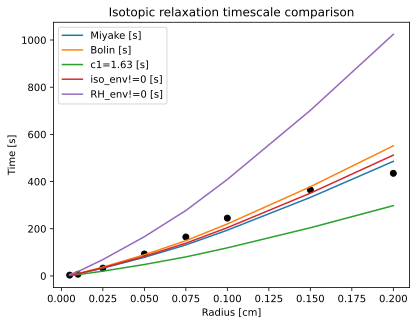

In [14]:
fig, ax = plt.subplots()
for variant, time in adjustment_time_frame.items():
    if variant != 'Radius [cm]':
        ax.plot(in_unit(radii, si.cm), time * si.s, label=variant)
ax.scatter(in_unit(radii, si.cm), bolin_table_1['Adjustment time [s]'], color='k')
ax.set_title('Isotopic relaxation timescale comparison')
ax.set_xlabel('Radius [cm]')
ax.set_ylabel('Time [s]')
ax.legend()
show_plot('timescales_comparison.pdf')

## 

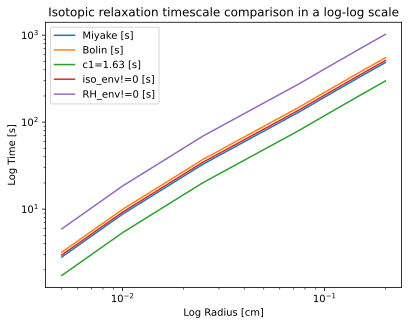

In [15]:
fig, ax = plt.subplots()
for variant, time in adjustment_time_frame.items():
    if variant != 'Radius [cm]':
        ax.loglog(in_unit(radii, si.cm), time * si.s, label=variant)
ax.set_title('Isotopic relaxation timescale comparison in a log-log scale')
ax.set_xlabel('Log Radius [cm]')
ax.set_ylabel('Log Time [s]')
ax.legend()
show_plot('timescales_comparison_loglog.pdf')